In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=2)


In [2]:
# get data
from eden.converter.graph.gspan import gspan_to_eden
from itertools import islice
def get_graphs(dataset_fname, size=100):
    return  islice(gspan_to_eden(dataset_fname),size)

#dataset_names = !cat NCI60/names
#dataset = dataset_names[4]
#dataset_fname = 'NCI60/' + dataset + '_orig_pos.gspan'
#print 'Working with dataset: %s' % dataset 

dataset_fname = 'bursi.pos.gspan'

In [3]:
%%time
# induce a grammar and train an estimator
training_graphs = get_graphs(dataset_fname, size=2000)

from graphlearn.graphlearn import GraphLearnSampler
from eden.graph import Vectorizer
sampler=GraphLearnSampler(radius_list=[0,1], thickness_list=[2],random_state=42447,
                          min_cip_count=2, min_interface_count=2,
                          vectorizer=Vectorizer(5))
#take nu% of data as outlier
sampler.fit(training_graphs, nu=0.25, n_jobs=-1)

print('graph grammar stats:')
n_instances, interface_counts, core_counts, cip_counts = sampler.grammar().size()
print('#instances: %d   #interfaces: %d   #cores: %d   #core-interface-pairs: %d' % (n_instances, interface_counts, core_counts, cip_counts))

sampler.save('tmp/sampler.ge')



Classifier:
SGDClassifier(alpha=0.000536345775989, average=False, class_weight=None,
       epsilon=0.1, eta0=0.148153533772, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='log', n_iter=39, n_jobs=1,
       penalty='l1', power_t=0.773230048147, random_state=None,
       shuffle=True, verbose=0, warm_start=False)

Predictive performance:
            accuracy: 1.000 +- 0.000
           precision: 1.000 +- 0.000
              recall: 1.000 +- 0.000
                  f1: 1.000 +- 0.000
   average_precision: 1.000 +- 0.000
             roc_auc: 1.000 +- 0.000
#instances: 2000  #interfaces: 674   #cores: 123   #core-interface-pairs: 2115
graph grammar stats:
#instances: 2000   #interfaces: 674   #cores: 123   #core-interface-pairs: 2115
Saved model: tmp/sampler.ge
CPU times: user 4min 8s, sys: 12 s, total: 4min 20s
Wall time: 6min 39s


In [4]:
%%time
from graphlearn.graphlearn import GraphLearnSampler
sampler=GraphLearnSampler()
sampler.load('tmp/sampler.ge')

# graph sampling
graphs = get_graphs(dataset_fname, size=100)

id_start=34
id_end=id_start+12
from itertools import islice
graphs = islice(graphs,id_start,id_end)

# sample
n_steps=50
n_samples=2

from graphlearn.graphlearn import GraphLearnSampler
graphs = sampler.sample(graphs,
                        n_steps=n_steps, n_samples=n_samples,
                        target_orig_cip=False,
                        probabilistic_core_choice=True,
                        score_core_choice= False,
                        max_core_size_diff=-1,
                        burnin=1,
                        omit_seed=False,
                        max_cycle_size=0,
                        improving_threshold=.8, 
                        improving_linear_start=0.2,
                        accept_static_penalty=0.0,
                        n_jobs=1,
                        select_cip_max_tries=200,
                        keep_duplicates=True,
                       estimate_flowback=True)

Loaded model: tmp/sampler.ge
CPU times: user 9.94 s, sys: 264 ms, total: 10.2 s
Wall time: 11 s


WARNING you set estimate backflow. the implementation is a little sketchy so dont try this with weired graphs. 
preprocessing grammar
_sample_notes: None
accept_static_penalty: 0.0
batch_size: 10
    burnin: 1
complexity: 3
estimate_backflow: True
 estimator: CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.000536345775989, average=False, class_weight=None,
       epsilon=0.1, eta0=0.148153533772, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='log', n_iter=39, n_jobs=1,
       penalty='l1', power_t=0.773230048147, random_state=None,
       shuffle=True, verbose=0, warm_start=False),
            cv=2, method='sigmoid')
estimatorobject: <graphlearn.estimatorwrapper.EstimatorWrapper instance at 0x7ff6dba8e1b8>
feasibility_checker: <graphlearn.feasibility.FeasibilityChecker instance at 0x7ff6dba8e128>
generator_mode: False
hash_bitmask: 1048575
improving_linear_start: 10
improving_penalty_per_step: 0.0333333333333
improving_threshold: 40
keep_duplica

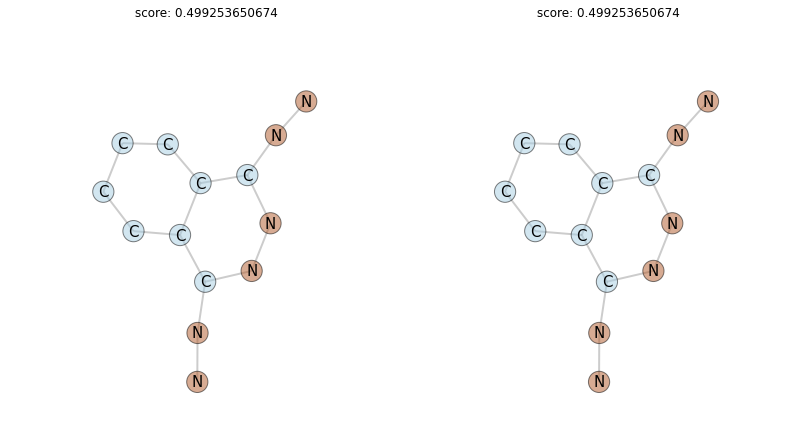

flow1: 0.955556
0 0
float division by zero
Traceback (most recent call last):
  File "graphlearn/graphlearn.py", line 349, in _sample
    candidate_graph = self._propose(graph)
  File "graphlearn/graphlearn.py", line 504, in _propose
    graph = self._propose_graph(graph)
  File "graphlearn/graphlearn.py", line 538, in _propose_graph
    self.reverse_direction_probability(graph,tmp,original_cip)
  File "graphlearn/graphlearn.py", line 571, in reverse_direction_probability
    value+= one/float(two)
ZeroDivisionError: float division by zero

Graph id: 35


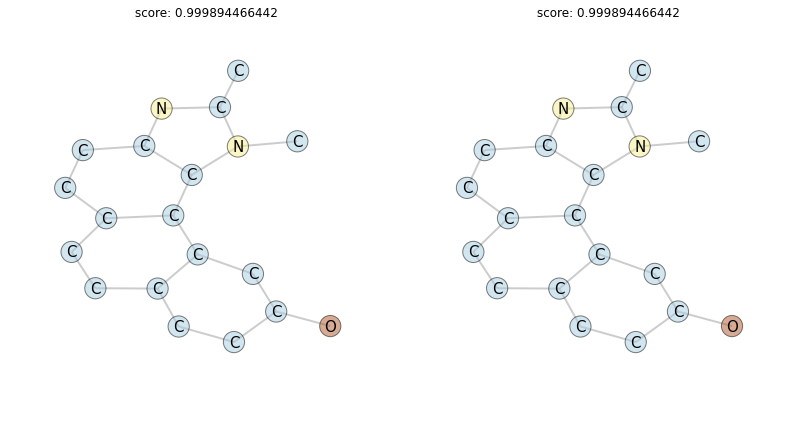

flow1: 0.923077
5 17
flow: 1.217195
_propose_graph: iteration 0 ; core 0 of 1 ; original_cips tried  0
flow1: 0.923077
25 0
float division by zero
Traceback (most recent call last):
  File "graphlearn/graphlearn.py", line 349, in _sample
    candidate_graph = self._propose(graph)
  File "graphlearn/graphlearn.py", line 504, in _propose
    graph = self._propose_graph(graph)
  File "graphlearn/graphlearn.py", line 538, in _propose_graph
    self.reverse_direction_probability(graph,tmp,original_cip)
  File "graphlearn/graphlearn.py", line 571, in reverse_direction_probability
    value+= one/float(two)
ZeroDivisionError: float division by zero

Graph id: 36


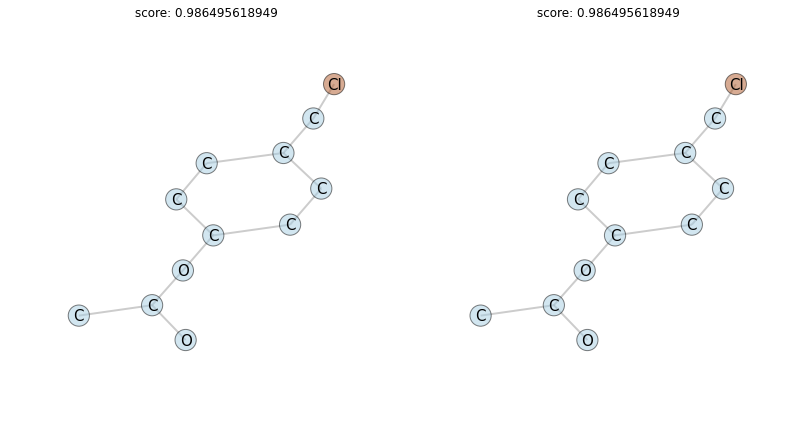

flow1: 0.945946
14 29
flow: 1.428705
_propose_graph: iteration 0 ; core 0 of 5 ; original_cips tried  0
flow1: 1.121212
2 28
flow: 1.192641
_propose_graph: iteration 1 ; core 0 of 27 ; original_cips tried  0
flow1: 1.000000
14 0
float division by zero
Traceback (most recent call last):
  File "graphlearn/graphlearn.py", line 349, in _sample
    candidate_graph = self._propose(graph)
  File "graphlearn/graphlearn.py", line 504, in _propose
    graph = self._propose_graph(graph)
  File "graphlearn/graphlearn.py", line 538, in _propose_graph
    self.reverse_direction_probability(graph,tmp,original_cip)
  File "graphlearn/graphlearn.py", line 571, in reverse_direction_probability
    value+= one/float(two)
ZeroDivisionError: float division by zero

Graph id: 37


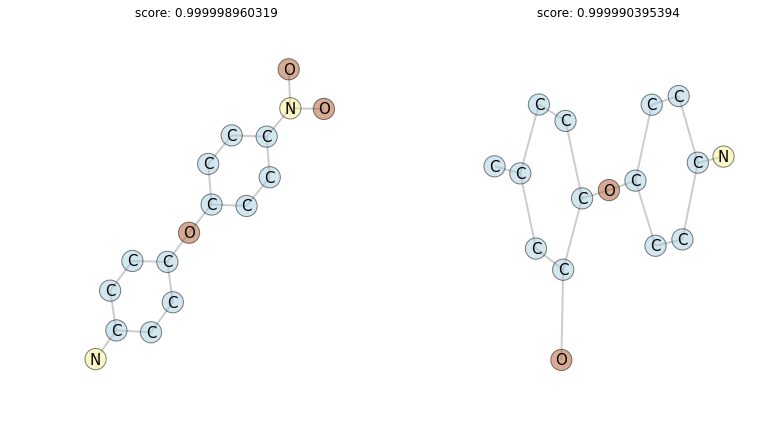

flow1: 0.955556
12 8
flow: 2.455556
_propose_graph: iteration 0 ; core 0 of 7 ; original_cips tried  0
flow1: 1.000000
17 0
float division by zero
Traceback (most recent call last):
  File "graphlearn/graphlearn.py", line 349, in _sample
    candidate_graph = self._propose(graph)
  File "graphlearn/graphlearn.py", line 504, in _propose
    graph = self._propose_graph(graph)
  File "graphlearn/graphlearn.py", line 538, in _propose_graph
    self.reverse_direction_probability(graph,tmp,original_cip)
  File "graphlearn/graphlearn.py", line 571, in reverse_direction_probability
    value+= one/float(two)
ZeroDivisionError: float division by zero

Graph id: 38


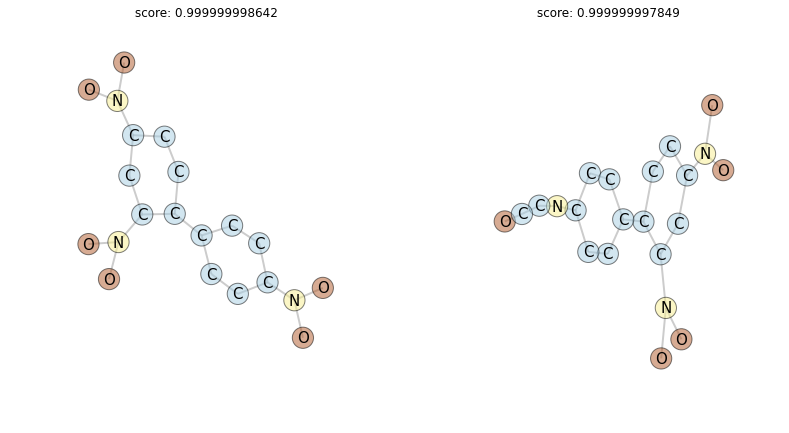

flow1: 0.916667
28 6
flow: 5.583333
_propose_graph: iteration 0 ; core 0 of 13 ; original_cips tried  0
flow1: 1.000000
0 0
float division by zero
Traceback (most recent call last):
  File "graphlearn/graphlearn.py", line 349, in _sample
    candidate_graph = self._propose(graph)
  File "graphlearn/graphlearn.py", line 504, in _propose
    graph = self._propose_graph(graph)
  File "graphlearn/graphlearn.py", line 538, in _propose_graph
    self.reverse_direction_probability(graph,tmp,original_cip)
  File "graphlearn/graphlearn.py", line 571, in reverse_direction_probability
    value+= one/float(two)
ZeroDivisionError: float division by zero

Graph id: 39


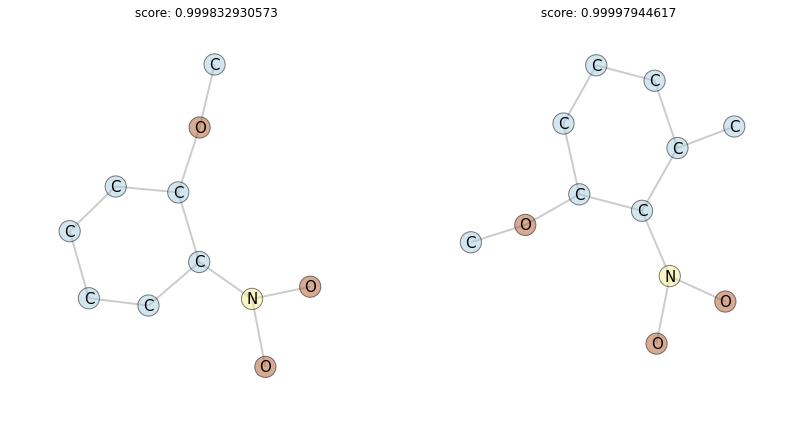

flow1: 1.000000
11 6
flow: 2.833333
_propose_graph: iteration 0 ; core 0 of 1 ; original_cips tried  0
flow1: 0.951220
0 2
flow: 0.951220
_propose_graph: iteration 1 ; core 0 of 16 ; original_cips tried  0
flow1: 1.000000
2 0
float division by zero
Traceback (most recent call last):
  File "graphlearn/graphlearn.py", line 349, in _sample
    candidate_graph = self._propose(graph)
  File "graphlearn/graphlearn.py", line 504, in _propose
    graph = self._propose_graph(graph)
  File "graphlearn/graphlearn.py", line 538, in _propose_graph
    self.reverse_direction_probability(graph,tmp,original_cip)
  File "graphlearn/graphlearn.py", line 571, in reverse_direction_probability
    value+= one/float(two)
ZeroDivisionError: float division by zero

Graph id: 40


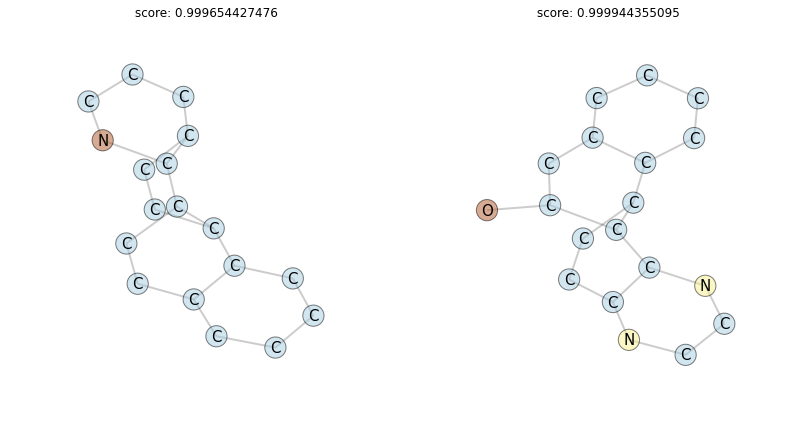

flow1: 1.040000
10 28
flow: 1.397143
_propose_graph: iteration 0 ; core 0 of 7 ; original_cips tried  0
flow1: 1.000000
9 17
flow: 1.529412
_propose_graph: iteration 1 ; core 0 of 1 ; original_cips tried  0
flow1: 1.000000
9 17
flow: 1.529412
_propose_graph: iteration 2 ; core 0 of 10 ; original_cips tried  0
flow1: 1.041667
49
Traceback (most recent call last):
  File "graphlearn/graphlearn.py", line 349, in _sample
    candidate_graph = self._propose(graph)
  File "graphlearn/graphlearn.py", line 504, in _propose
    graph = self._propose_graph(graph)
  File "graphlearn/graphlearn.py", line 538, in _propose_graph
    self.reverse_direction_probability(graph,tmp,original_cip)
  File "graphlearn/graphlearn.py", line 569, in reverse_direction_probability
    two=ops(graph_new,cip)
  File "graphlearn/graphlearn.py", line 558, in ops
    hash_bitmask=self.hash_bitmask, filter=self.node_entity_check)
  File "graphlearn/graphtools.py", line 106, in extract_core_and_interface
    dist = nx.s

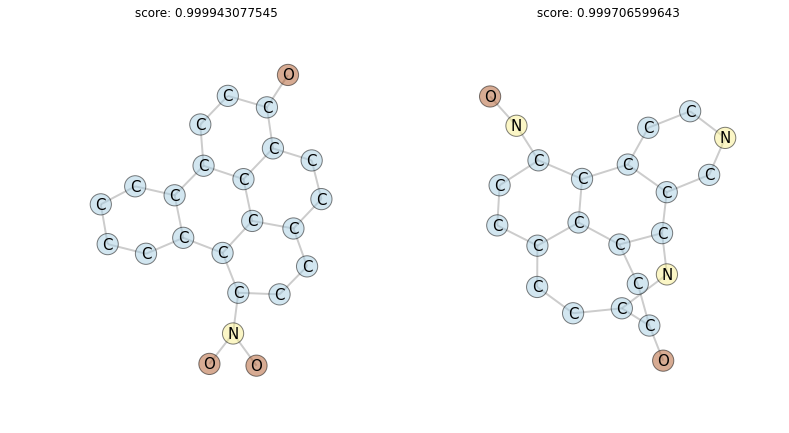

flow1: 0.963964
35 0
float division by zero
Traceback (most recent call last):
  File "graphlearn/graphlearn.py", line 349, in _sample
    candidate_graph = self._propose(graph)
  File "graphlearn/graphlearn.py", line 504, in _propose
    graph = self._propose_graph(graph)
  File "graphlearn/graphlearn.py", line 538, in _propose_graph
    self.reverse_direction_probability(graph,tmp,original_cip)
  File "graphlearn/graphlearn.py", line 571, in reverse_direction_probability
    value+= one/float(two)
ZeroDivisionError: float division by zero

Graph id: 42


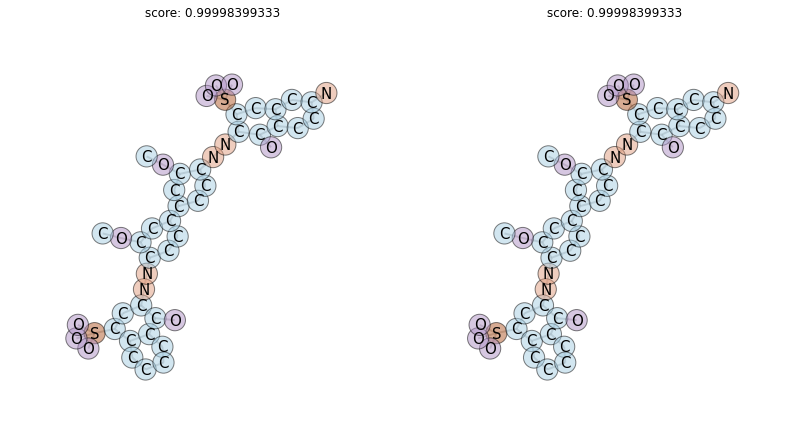

flow1: 1.000000
22 28
flow: 1.785714
_propose_graph: iteration 0 ; core 0 of 1 ; original_cips tried  0
flow1: 1.066667
10 10
flow: 2.066667
_propose_graph: iteration 1 ; core 0 of 7 ; original_cips tried  0
flow1: 1.250000
0 8
flow: 1.250000
_propose_graph: iteration 2 ; core 0 of 27 ; original_cips tried  0
flow1: 1.200000
6 0
float division by zero
Traceback (most recent call last):
  File "graphlearn/graphlearn.py", line 349, in _sample
    candidate_graph = self._propose(graph)
  File "graphlearn/graphlearn.py", line 504, in _propose
    graph = self._propose_graph(graph)
  File "graphlearn/graphlearn.py", line 538, in _propose_graph
    self.reverse_direction_probability(graph,tmp,original_cip)
  File "graphlearn/graphlearn.py", line 571, in reverse_direction_probability
    value+= one/float(two)
ZeroDivisionError: float division by zero

Graph id: 43


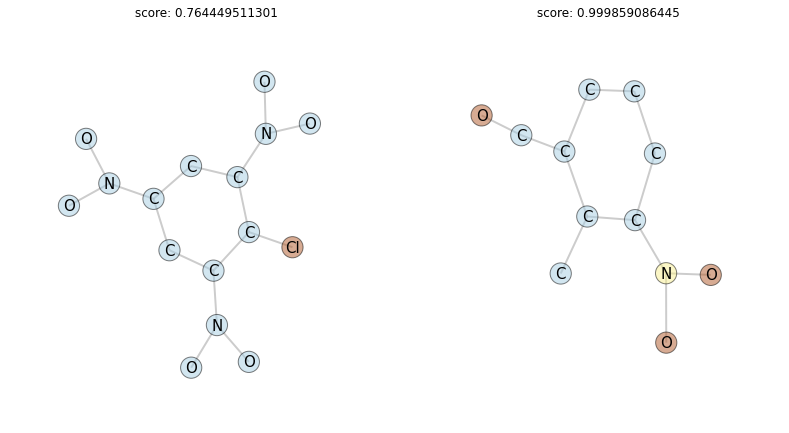

flow1: 0.950000
5 0
float division by zero
Traceback (most recent call last):
  File "graphlearn/graphlearn.py", line 349, in _sample
    candidate_graph = self._propose(graph)
  File "graphlearn/graphlearn.py", line 504, in _propose
    graph = self._propose_graph(graph)
  File "graphlearn/graphlearn.py", line 538, in _propose_graph
    self.reverse_direction_probability(graph,tmp,original_cip)
  File "graphlearn/graphlearn.py", line 571, in reverse_direction_probability
    value+= one/float(two)
ZeroDivisionError: float division by zero

Graph id: 44


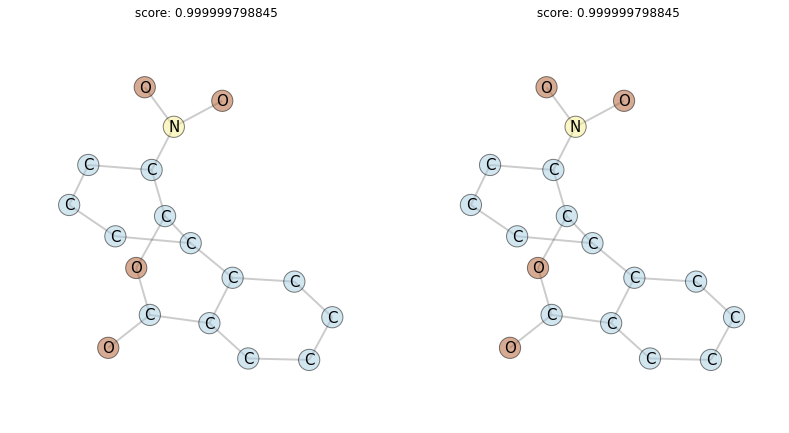

flow1: 0.882353
45 17
flow: 3.529412
_propose_graph: iteration 0 ; core 0 of 27 ; original_cips tried  0
flow1: 0.962264
9 3
flow: 3.962264
_propose_graph: iteration 1 ; core 0 of 10 ; original_cips tried  0
flow1: 0.963636
14 3
flow: 5.630303
_propose_graph: iteration 2 ; core 0 of 3 ; original_cips tried  0
flow1: 1.000000
0 0
float division by zero
Traceback (most recent call last):
  File "graphlearn/graphlearn.py", line 349, in _sample
    candidate_graph = self._propose(graph)
  File "graphlearn/graphlearn.py", line 504, in _propose
    graph = self._propose_graph(graph)
  File "graphlearn/graphlearn.py", line 538, in _propose_graph
    self.reverse_direction_probability(graph,tmp,original_cip)
  File "graphlearn/graphlearn.py", line 571, in reverse_direction_probability
    value+= one/float(two)
ZeroDivisionError: float division by zero

Graph id: 45


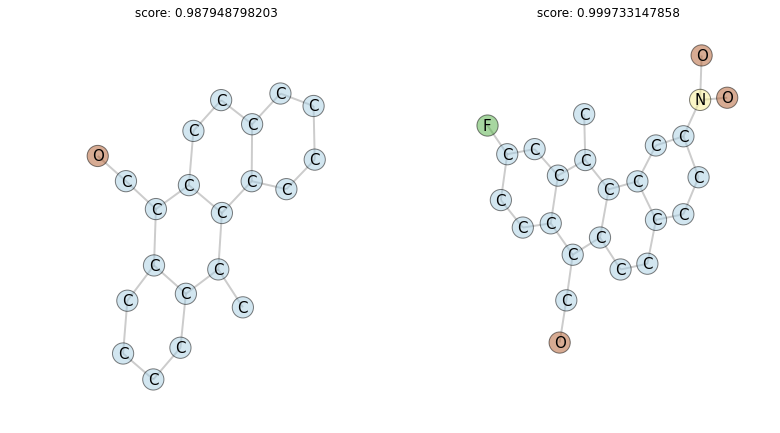

CPU times: user 9.77 s, sys: 1.34 s, total: 11.1 s
Wall time: 13.1 s


In [5]:
%%time
# plot examples of sampling paths
from graphlearn.utils.draw import  graphlearn_draw, get_score_of_graph
scores=[]
ids=range(id_start,id_end)
for i,graph in enumerate(graphs):
    print 'Graph id: %d'%(ids[i])
    scores.append(graph.graph['sampling_info']['score_history'])
    path_graphs = graph.graph['sampling_info']['graphs_history']
    graphlearn_draw(path_graphs,
                   n_graphs_per_line=6, size=7, 
                   colormap='Paired', invert_colormap=False,node_border=0.5, vertex_color='_labels_',
                   vertex_alpha=0.5, edge_alpha=0.2, node_size=450,
                   headlinehook=get_score_of_graph)

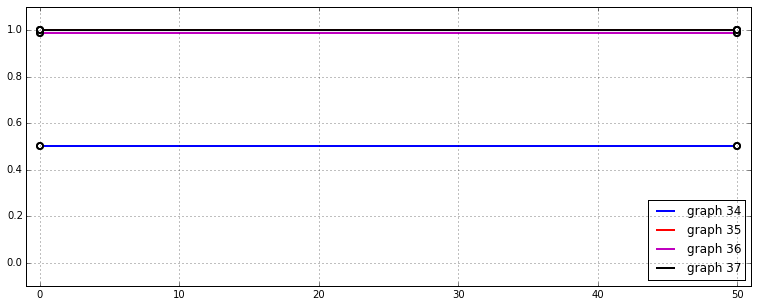

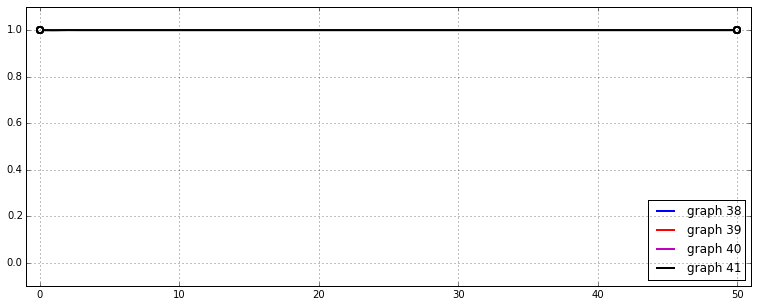

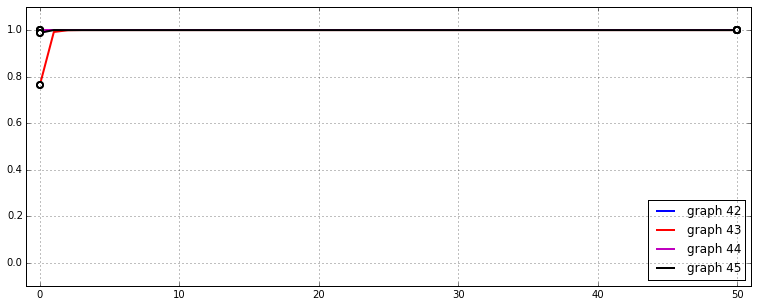

CPU times: user 788 ms, sys: 12 ms, total: 800 ms
Wall time: 809 ms


In [6]:
%%time
# plot sampling path score
from itertools import islice
import numpy as np
import pylab as plt
markevery=n_steps/(n_samples-1)
step=1
num_graphs_per_plot=4
num_plots=np.ceil([len(scores)/num_graphs_per_plot])
for i in range(num_plots):
    plt.figure(figsize=(13,5))
    for j,score in enumerate(scores[i*num_graphs_per_plot:i*num_graphs_per_plot+num_graphs_per_plot]):
        data = list(islice(score,None, None, step))
        plt.plot(data, linewidth=2, label='graph %d'%(j+i*num_graphs_per_plot+id_start))
        plt.plot(data, linestyle='None',markevery=markevery, markerfacecolor='white', marker='o', markeredgewidth=2,markersize=6)
    plt.legend(loc='lower right')
    plt.grid()
    plt.xlim(-1,n_steps+1)
    plt.ylim(-0.1,1.1)
    plt.show()

.